<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a2/dl_assignment2_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

#### Show the environment

In [80]:
!nvidia-smi
print()
print()
print('=' * 80)
print()
print()
!df -h
print()
print()
print('=' * 80)
print()
print()
!free -m
print()
print()
print('=' * 80)
print()
print()
!lscpu

Thu Apr 22 12:30:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |    480MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Setup logging

In [39]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import logging
import sys
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import shutil
import zipfile
import h5py
import gc
import IPython

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

#### Mount Google Drive And Copy Files

In [38]:
drive.mount('/content/gdrive')

if (os.path.exists("/root/imagedata")):
    ret = shutil.rmtree("/root/imagedata")
os.mkdir("/root/imagedata")
shutil.copyfile( \
    "/content/gdrive/MyDrive/DeepLearningAssignment2/earth_data.zip",
    "/root/imagedata/earth_data.zip")

!cd /root/imagedata && unzip earth_data.zip && rm -f earth_data.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  earth_data.zip
  inflating: earth_data.h5           


#### Extract train and test instances

In [41]:
def loadDataH5():
    with h5py.File('/root/imagedata/earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
        return trainX, trainY, valX, valY

trainX, trainY, valX, valY = loadDataH5()

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


# Question 1 Part A

### Build a Baseline

(19200, 9)
(19200,) (19200, 9)
(64, 64, 3) 9


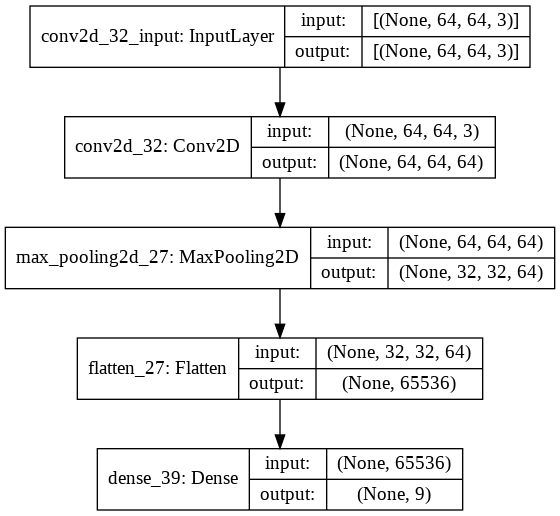

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 9)                 589833    
Total params: 591,625
Trainable params: 591,625
Non-trainable params: 0
_________________________________________________________________
None


In [99]:
class BaselineShallowNet:
    @staticmethod
    def build(inshape, nlabels):
        print(inshape, nlabels)
        inputShape = trainX[0].shape
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', \
                  input_shape=inshape, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        plot = tf.keras.utils.plot_model(model, show_shapes=True, \
                                         expand_nested=True)
        IPython.display.display(plot)
        return model

n_classes = len(np.unique(np.concatenate((trainY, valY))))
onehot_trainY = np.eye(n_classes)[trainY]
onehot_valY = np.eye(n_classes)[valY]
print(onehot_trainY.shape)
print(trainY.shape, onehot_trainY.shape)
model = BaselineShallowNet.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(model.summary())